# Test and visualize best model


Testing new model with regularization on new dataset after cleaning
* load test dataset
* visualize test datset
* load model
* run model on the test batch
* visualize results

Using new collected dataset "Pharec_toy_dataset_v1", modified by decreasing number of apple images

## Imports

In [1]:
import pathlib
import os
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras

In [2]:
import tensorflow_addons as tfa

## Load dataset

In [3]:
dataset_dir = pathlib.Path("../toy_dataset/")
model_dir = pathlib.Path('../phi_models/')
checkpoint_dir = pathlib.Path('../phi_checkpoints/')

In [4]:
dataset_dirs = os.listdir(dataset_dir)
print(dataset_dirs)

['phish_images', 'trusted_images']


In [5]:
dataset_phish_dir = dataset_dirs[0]
dataset_trusted_dir = dataset_dirs[1]

In [6]:
trusted_list = os.listdir(dataset_dir/dataset_trusted_dir)
trusted_number_images = [len(os.listdir(dataset_dir/f'{dataset_trusted_dir}/{site}')) for site in trusted_list]

phish_list = os.listdir(dataset_dir/dataset_phish_dir)
phish_number_images = len(phish_list)

print(f"Number of domains in trusted list: {len(trusted_list)}, with {sum(trusted_number_images)} images")
print("The trusted list:")
print([(site, n) for site, n in zip(trusted_list, trusted_number_images)])
print(f"\n\nNumber of images in phishing list: {phish_number_images} images")
# print("The phishing list:")
# print(phish_list)

print(f"Total number of images {phish_number_images + sum(trusted_number_images)}")
print("Dataset collected by Ali from the Pharec team")

Number of domains in trusted list: 69, with 6801 images
The trusted list:
[('aliexpress_com_images', 19), ('apple_com_images', 570), ('balady_gov_sa_images', 65), ('citc_gov_sa_images', 102), ('hrsd_gov_sa_images', 100), ('loungekey_com_images', 28), ('mewa_gov_sa_images', 121), ('mlsd_gov_sa_images', 83), ('moe_gov_sa_images', 106), ('moh_gov_sa_images', 86), ('najiz_sa_images', 7), ('portal_ca_gov_sa_images', 14), ('sabq_org_images', 54), ('sa_iherb_com_images', 220), ('sa_zain_com_images', 70), ('store_steampowered_com_images', 321), ('stripe_com_images', 391), ('thmanyah_com_images', 52), ('www_airarabia_com_images', 28), ('www_airbnb_com_images', 35), ('www_al-jazirah_com_images', 63), ('www_alahli_com_images', 123), ('www_alibaba_com_images', 56), ('www_americanexpress_com_images', 147), ('www_americanexpress_com_sa_images', 63), ('www_anb_com_sa_images', 54), ('www_aramex_com_images', 52), ('www_argaam_com_images', 399), ('www_att_com_images', 32), ('www_bankaljazira_com_images'

### Params

In [7]:
model_name = "wpd4"
batch_size = 16
img_height = 683 // 2
img_width = 1024 // 2

rest_split_ratio = 0.2
test_split_ratio = 0.2

### init dataset objects and splits

In [8]:
train_trusted_ds = tf.keras.preprocessing.image_dataset_from_directory(
  dataset_dir/dataset_trusted_dir,
  validation_split=rest_split_ratio,
  subset="training",
  seed=1324,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  smart_resize=True
)

Found 6801 files belonging to 69 classes.
Using 5441 files for training.


In [9]:
train_trusted_ds.cardinality().numpy() * 16

5456

In [10]:
rest_trusted_ds = tf.keras.preprocessing.image_dataset_from_directory(
  dataset_dir/dataset_trusted_dir,
  label_mode = 'categorical',
  validation_split=rest_split_ratio,
  subset="validation",
  seed=132,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  smart_resize=True
)

Found 6801 files belonging to 69 classes.
Using 1360 files for validation.


In [11]:
class_names = train_trusted_ds.class_names
num_classes = len(class_names)
# print("Number of classes", num_classes)
# print(list(enumerate(class_names)))

In [12]:
# train_ds = train_trusted_ds.concatenate(train_phi_ds)
# rest_ds = rest_trusted_ds.concatenate(rest_phi_ds)
train_ds = train_trusted_ds
rest_ds = rest_trusted_ds

In [13]:
train_ds.cardinality().numpy()

341

In [14]:
rest_batches = rest_ds.cardinality().numpy()
print(rest_batches)

85


In [15]:
val_ds = rest_ds.skip(int(rest_batches * test_split_ratio))
test_ds = rest_ds.take(int(rest_batches * test_split_ratio))

In [16]:
val_ds.cardinality().numpy()

68

In [17]:
test_ds.cardinality().numpy()

17

## Visualize data

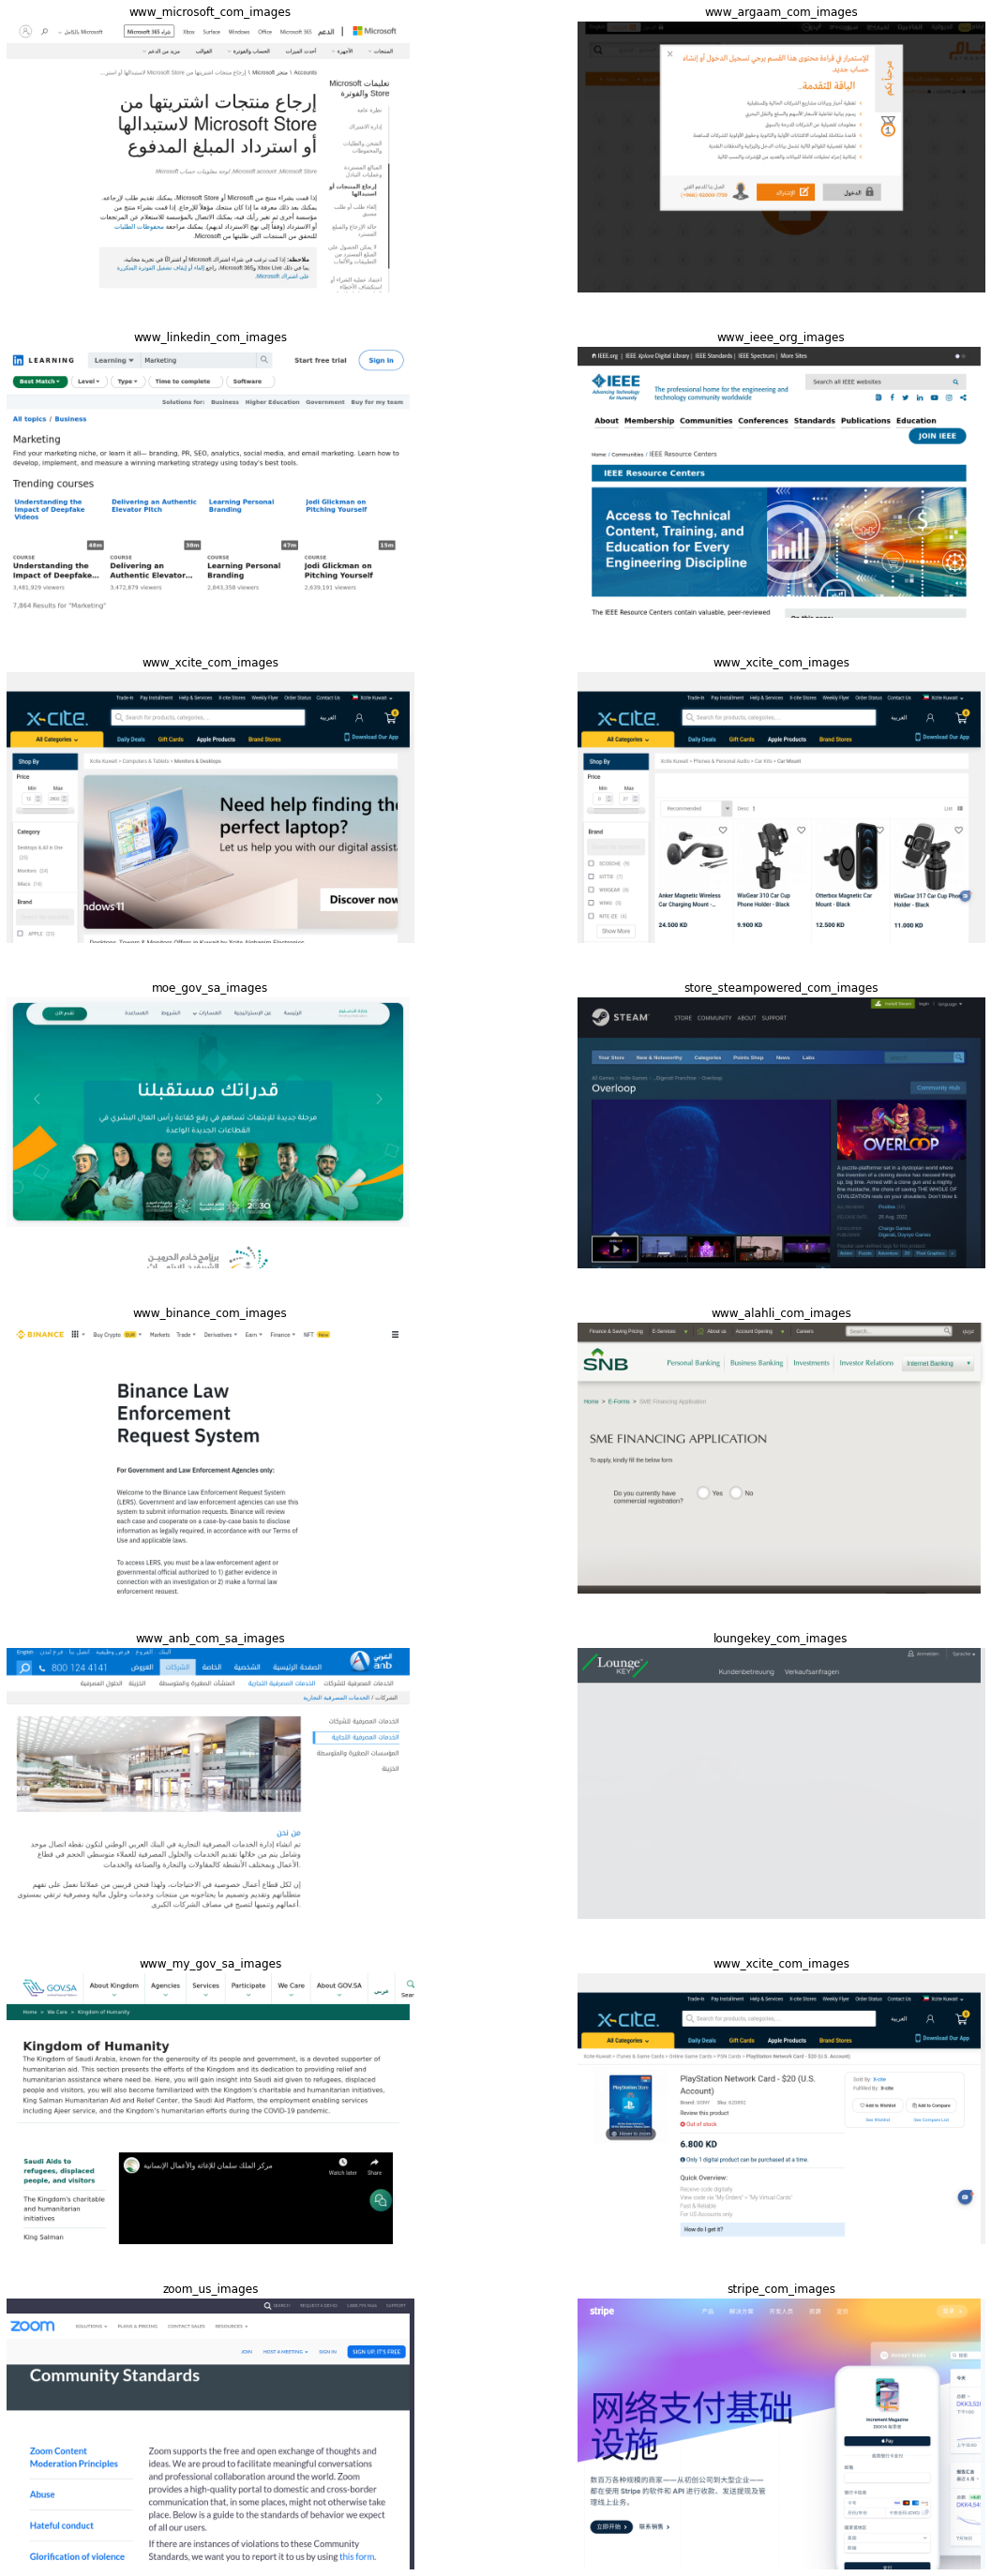

In [19]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 50))
for images, labels in test_ds.take(1):
    imgs = images
    class_labels = labels.numpy().argmax(axis=-1)
    for i in range(batch_size):
        ax = plt.subplot(8, 2, i + 1)
        plt.imshow(imgs[i].numpy().astype("uint8"))
        plt.title(class_names[int(class_labels[i])])
        plt.axis("off")

## Load model

In [23]:
# change filename to the model you want to load
model_filename = "2022-09-06_19;51;12.137745_wpd4_valacc0.9816_e31"
# model2 = keras.models.load_model(
#     model_dir / model_filename,
#     compile=True)
model = keras.models.load_model(
    checkpoint_dir / model_filename,
    # compile=True
)

## Prepare metrics

In [24]:
class FromLogitsMixin:
  def __init__(self, from_logits=False, *args, **kwargs):
    super().__init__(*args, **kwargs)
    self.from_logits = from_logits

  def update_state(self, y_true, y_pred, sample_weight=None):
    if self.from_logits:
      y_pred = tf.nn.softmax(y_pred)
    return super().update_state(y_true, y_pred, sample_weight)


class AUC(FromLogitsMixin, tf.metrics.AUC):
  ...

class BinaryAccuracy(FromLogitsMixin, tf.metrics.BinaryAccuracy):
  ...

class TruePositives(FromLogitsMixin, tf.metrics.TruePositives):
  ...

class FalsePositives(FromLogitsMixin, tf.metrics.FalsePositives):
  ...

class TrueNegatives(FromLogitsMixin, tf.metrics.TrueNegatives):
  ...

class FalseNegatives(FromLogitsMixin, tf.metrics.FalseNegatives):
  ...

class Precision(FromLogitsMixin, tf.metrics.Precision):
  ...

class Recall(FromLogitsMixin, tf.metrics.Recall):
  ...

class F1Score(FromLogitsMixin, tfa.metrics.F1Score):
  ...

class MultiLabelConfusionMatrix(FromLogitsMixin, tfa.metrics.MultiLabelConfusionMatrix):
  ...

In [25]:
model.compile(
    optimizer='adam', 
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), 
    metrics=[
        'accuracy',
        MultiLabelConfusionMatrix(from_logits=True, num_classes=num_classes),
        F1Score(from_logits=True, num_classes=num_classes)
#         F1Score(from_logits=True, num_classes=num_classes, average='macro', threshold=0.5)
    ]
)

## Evaluate (test)

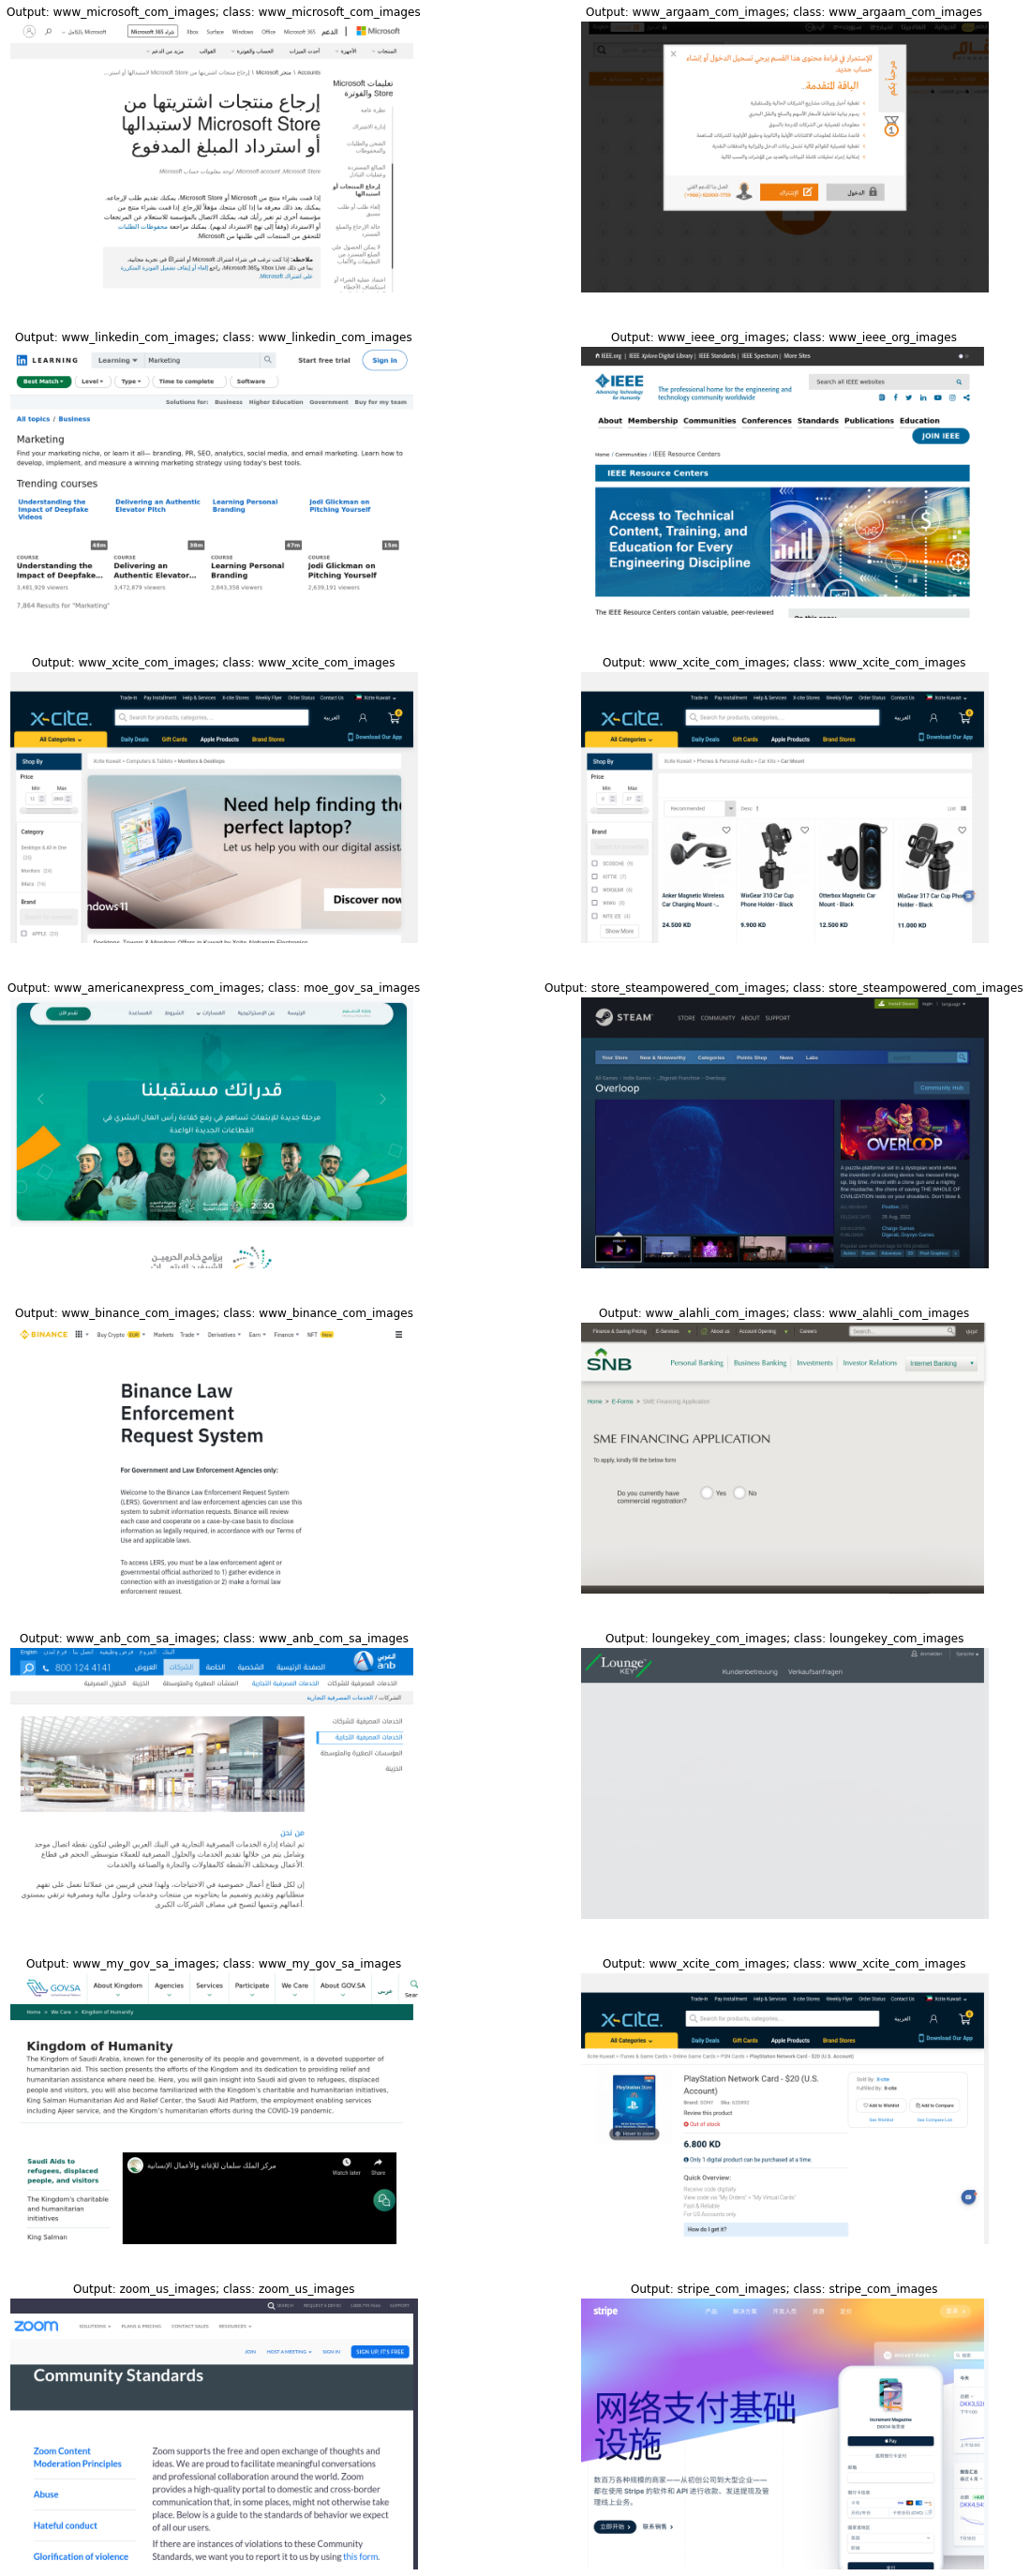

In [26]:
plt.figure(figsize=(20, 50))
probits = tf.nn.softmax(model.predict(imgs)).numpy()
for i in range(batch_size):
    ax = plt.subplot(8, 2, i + 1)
    plt.imshow(imgs[i].numpy().astype("uint8"))
    plt.title(f"Output: {class_names[np.argmax(probits[i])]}; class: {class_names[int(class_labels[i])]}")
    plt.axis("off")

In [27]:
test_results = model.evaluate(test_ds)
print("test loss, test accuracy, test confusionMatrix, test F1 score")
print(test_results[:-2] + [test_results[-2].mean()] + [test_results[-1].mean()])

17/17 [==============================] - 2s 76ms/step - loss: 76.3065 - accuracy: 0.9522 - Multilabel_confusion_matrix: 68.0000 - f1_score: 0.7491
test loss, test accuracy, test confusionMatrix, test F1 score
[76.3064956665039, 0.9522058963775635, 68.0, 0.74912184]


In [28]:
test_results[-2].mean(axis=0)

array([[2.6788406e+02, 1.7391305e-01],
       [1.8840580e-01, 3.7536232e+00]], dtype=float32)